# Import Libraries

In [ ]:
!pip install gradio
!pip install facenet-pytorch
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.4/312.4 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 1.2 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.2-py3-none-any.whl size=558

In [ ]:
import gradio as gr
import torch
import torch.nn.functional as F
from facenet_pytorch import MTCNN, InceptionResnetV1
import numpy as np
from PIL import Image
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Download and Load Model

In [ ]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

mtcnn = MTCNN(
    select_largest=False,
    post_process=False,
    device=DEVICE
).to(DEVICE).eval()

In [ ]:
model = InceptionResnetV1(
    pretrained="vggface2",
    classify=True,
    num_classes=1,
    device=DEVICE
)

checkpoint = torch.load("/content/drive/MyDrive/Resnext_inception/resnetinceptionv1_epoch_32.pth", map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE)
model.eval()

  0%|          | 0.00/107M [00:00<?, ?B/s]

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

# Model Inference

In [ ]:
def predict(model, input_image: Image.Image):
    """Predict the label of the input_image"""
    input_image_tensor = mtcnn(input_image)
    if input_image_tensor is None:
        raise Exception('No face detected')

    input_image_tensor = input_image_tensor.unsqueeze(0)  # add the batch dimension
    input_image_tensor = F.interpolate(input_image_tensor, size=(256, 256), mode='bilinear', align_corners=False)

    input_image_tensor = input_image_tensor.to(DEVICE)
    input_image_tensor = input_image_tensor.to(torch.float32)
    input_image_tensor /= 255.0

    # target_layers = [model.block8.branch1[-1]]

    # cam = GradCAM(model=model)
    # targets = [ClassifierOutputTarget(0)]

    # grayscale_cam = cam(input_tensor=input_image_tensor, target_layers=target_layers, target_category=None)

    # grayscale_cam = grayscale_cam[0, :]
    # visualization = show_cam_on_image(input_image_tensor.squeeze(0).permute(1, 2, 0).cpu().detach().numpy(), grayscale_cam, use_rgb=True)
    # face_with_mask = cv2.addWeighted(input_image_tensor.squeeze(0).permute(1, 2, 0).cpu().detach().numpy(), 1, visualization, 0.5, 0)

    with torch.no_grad():
        output = torch.sigmoid(model(input_image_tensor).squeeze(0))
        prediction = "real" if output.item() < 0.5 else "fake"

        real_prediction = 1 - output.item()
        fake_prediction = output.item()

        confidences = {
            'real': real_prediction,
            'fake': fake_prediction
        }
    # return confidences, face_with_mask
    return confidences


# Gradio Interface

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the image
image_path = "/content/drive/MyDrive/Resnext_inception/examples/fake_frame_1.png"  # Replace "path_to_your_image.jpg" with the actual path to your image
input_image = Image.open(image_path)

# Call the predict function
confidences = predict(model, input_image)
print(confidences)


{'real': 0.00010454654693603516, 'fake': 0.999895453453064}


In [ ]:
def classify_image(model, image_path, threshold=0.5):
  input_image = Image.open(image_path)
  confidences = predict(model, input_image)

  # Displaying the image
  img = cv2.imread(image_path)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  print(img_rgb.shape)
  plt.imshow(img_rgb)
  plt.axis('off')
  plt.title(f'{confidences}')
  plt.show()

    # # Classify the image based on the threshold
    # if prediction > threshold:
    #     print("The image is classified as real.")
    # else:
    #     print("The image is classified as fake.")

(1080, 1920, 3)


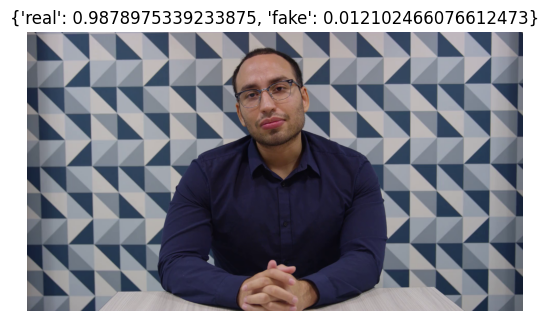

In [ ]:
image_path = '/content/drive/MyDrive/Resnext_inception/examples/real_frame_16.png'
classify_image(model, image_path)

(680, 657, 3)


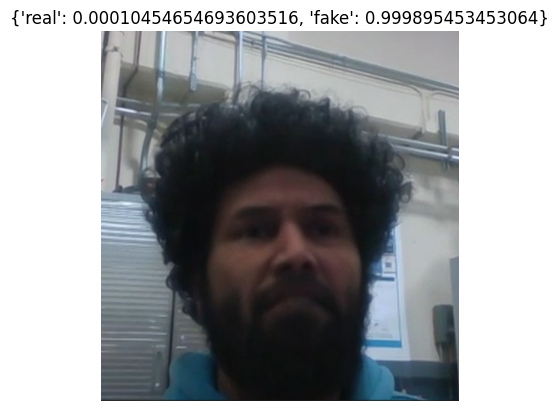

DisabledFunctionError: cv2.imshow() is disabled in Colab, because it causes Jupyter sessions
to crash; see https://github.com/jupyter/notebook/issues/3935.
As a substitution, consider using
  from google.colab.patches import cv2_imshow


In [ ]:
image_path = '/content/drive/MyDrive/Mesonet/data/df/Screenshot 2024-03-27 045230.png'
input_image = Image.open(image_path)
reshaped_image = input_image.resize((1920, 1080))
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img_rgb.shape)
plt.imshow(img_rgb)
plt.axis('off')
plt.title(f'{confidences}')
plt.show()

# Convert the reshaped image from PIL format to OpenCV format
reshaped_image_cv = cv2.cvtColor(np.array(reshaped_image), cv2.COLOR_RGB2BGR)

# Display the reshaped image using OpenCV
cv2.imshow("Reshaped Image", reshaped_image_cv)
cv2.waitKey(0)
cv2.destroyAllWindows()

# confidences = predict(model, reshaped_image)
# Displaying the image


In [ ]:
import cv2

def resize_image_with_aspect_ratio(image_path, output_width, output_height):
    # Read the image
    image = cv2.imread(image_path)

    # Get the dimensions of the input image
    height, width, _ = image.shape
    print("original", image.shape)
    # Calculate aspect ratios
    input_aspect_ratio = width / height
    output_aspect_ratio = output_width / output_height

    # Determine scaling factors
    if input_aspect_ratio > output_aspect_ratio:
        scale_factor = output_width / width
    else:
        scale_factor = output_height / height

    # Resize the image
    resized_image = cv2.resize(image, (0, 0), fx=scale_factor, fy=scale_factor)
    print("resized image", resized_image.shape)
    return resized_image

# Example usage
input_image_path = '/content/drive/MyDrive/Mesonet/data/df/Screenshot 2024-03-27 045230.png'
output_width = 1920  # Adjusted according to your requirement
output_height = 1080  # Adjusted according to your requirement

resized_image = resize_image_with_aspect_ratio(input_image_path, output_width, output_height)

# Save or display the resized image
cv2.imwrite('resized_image.jpg', resized_image)
img_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
print(img_rgb.shape)
plt.imshow(img_rgb)
plt.axis('off')
plt.show()
